# Statistical moments across GM-WM depth from histology and qMRI

### Libraries

In [1]:
import pandas as pd
import numpy as np
import nibabel as nb
import seaborn as sns
import os
import glob
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainspace.datasets import load_mask
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect
from brainstat.datasets.base import combine_surfaces
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import skew, kurtosis
from cmcrameri import cm

### Load surfaces and masks

In [2]:
# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k_int = np.concatenate((mask_lh, mask_rh), axis=0)
# Labels and boolean mask
mask_5k = mask_5k_int != 0
mask_32k = load_mask(join=True)

### Load intensity profiles

In [23]:
BBgm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/BB_GM_IPs_5k.npy') # BigBrain GM intensity profiles
BBswm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/BB_SWM_IPs_5k.npy') # BigBrain SWM intensity profiles
ABgm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/AHEAD_gm_Bieloschowsky.npy') # Ahead-Bielschowsky GM intensity profiles
ABfswm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/AHEAD_Bieloschowsky_FS.npy') # Ahead-Bielschowsky SWM intensity profiles
APgm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/AHEAD_gm_Parvalbumin.npy') # Ahead-Parvalbumin GM intensity profiles
APfswm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/AHEAD_Parvalbumin_FS.npy') # Ahead-Parvalbumin SWM intensity profiles
T1map_gm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/PNC-10sub_T1map_gmIP.npy') # T1 map GM intensity profiles
T1map_swm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/PNC-10sub_T1map_swmIP.npy') # T1 map SWM intensity profiles
MTSAT_gm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/PNC-10sub_MTsatnew_gmIP.npy') # MTsat GM intensity profiles
MTSAT_swm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/PNC-10sub_MTsatnew_swmIP.npy') # MTsat SWM intensity profiles

### Stack GM and SWM inensity profiles

In [24]:
BB_int_profile = np.vstack((BBgm_int, BBswm_int)) # BigBrain
AB_int_profile = np.vstack((ABgm_int, ABfswm_int)) # AHEAD - Bielschowsky
AP_int_profile = np.vstack((APgm_int, APfswm_int)) # AHEAD - Parvalbumin
T1map_int_profile = np.vstack((T1map_gm_int, np.flip(T1map_swm_int, axis=0))) # T1 map
MTSAT_int_profile = np.vstack((MTSAT_gm_int, np.flip(MTSAT_swm_int, axis=0))) # MTsat

### Functions

## F1: Statistical moments by deepth

In [5]:
def plot_deepth(ax, intensity_moment, title='', cbar=None, xlab='', cmap='mako_r'):
    # Create a scatter plot with lines
    ax.patch.set_alpha(0.0)  # Set the background of the axes to be transparent

    if intensity_moment.shape[0] == 30:
        # Scatter plot with lines
        deepth = np.arange(2.8, -3.2, -0.2)
        ax.plot(intensity_moment, deepth, color='gray', alpha=0.5)
        scatter = ax.scatter(intensity_moment, deepth, c=intensity_moment, cmap=cmap, s=150, alpha=1, linewidth=8)
    elif intensity_moment.shape[0] == 50:
        deepth = np.arange(2.88, -3.12, -0.12)
        ax.plot(intensity_moment, deepth, color='gray', alpha=0.5)
        scatter = ax.scatter(intensity_moment, deepth, c=intensity_moment, cmap=cmap, s=130, alpha=1, linewidth=4)
    
    # Customize ticks and labels
    ax.set_xlabel('', fontsize=14)  # Increase font size for x-label
    ax.set_ylabel('', fontsize=14)  # Increase font size for y-label
    ax.set_title(title, fontsize=30)  # Increase font size for title

    # Remove upper and right lines of the boxplot
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Draw horizontal striped lines
    ax.axhline(y=0, color='lightgray', linestyle='--', linewidth=3)
    ax.axhline(y=-1.0, color='lightgray', linestyle='--', linewidth=3)
    ax.axhline(y=-2.0, color='lightgray', linestyle='--', linewidth=3)

    # Adjust tick label sizes (for both x and y axes)
    ax.tick_params(axis='both', labelsize=20)  # Increase font size for both x and y tick labels
    
    if cbar:
        # Add color bar at the bottom
        cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.2)
        cbar.set_label(xlab)

def plot_intensity_moments(extracted_rows, mask_5k):
    """
    This function calculates and plots the mean, standard deviation, skewness, and kurtosis 
    for intensity data, then visualizes the results in subplots.

    Parameters:
    extracted_rows (numpy.ndarray): The intensity data to be analyzed.
    mask_5k (numpy.ndarray): A mask to select the relevant region of the data for analysis.
    """
    # Calculate the mean, standard deviation, skewness, and kurtosis along axis=1
    mean_intensity = np.mean(extracted_rows[:, mask_5k], axis=1)
    std_intensity = np.std(extracted_rows[:, mask_5k], axis=1)
    skew_intensity = skew(extracted_rows[:, mask_5k], axis=1)
    kurt_intensity = kurtosis(extracted_rows[:, mask_5k], axis=1)

    # Create a 1x4 subplot layout
    fig, axs = plt.subplots(1, 4, figsize=(20, 7))
    fig.patch.set_alpha(0.0)  # Set the background of the figure to be transparent

    # Plot each moment using a function like `plot_deepth_hist`
    plot_deepth(axs[0], mean_intensity, title='Mean', cbar=None, xlab='Mean', cmap='mako_r')
    plot_deepth(axs[1], std_intensity, title="SD", cbar=None, xlab='Standard deviation', cmap='cmc.lapaz_r')
    plot_deepth(axs[2], skew_intensity, title='Skewness', cbar=None, xlab='Skewness', cmap='cmc.navia_r')
    plot_deepth(axs[3], kurt_intensity, title='Kurtosis', cbar=None, xlab='Kurtosis', cmap='cmc.acton_r')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

## F2: Ridge plot for visualizing the intensity distributions

In [6]:
def plot_ridgeplot(matrix, matrix_df=None, Cmap='rocket', Range=(0.5, 2), Xlab="SUVR value", save_path=None, title=None, mean_line=False, WM=15):
    """
    Parameters:
    - matrix: numpy array
        The matrix to be plotted.
    - matrix_df: pandas DataFrame, optional
        The DataFrame containing additional information about the matrix.
    - Cmap: str, optional
        The colormap to be used for the ridgeplot. Default is 'rocket'.
    - Range: tuple, optional
        The range of values for the x-axis. Default is (0.5, 2).
    - Xlab: str, optional
        The label for the x-axis. Default is "SUVR value".
    - save_path: str, optional
        The file path to save the plot. If not provided, the plot will be displayed.
    - title: str, optional
        The title of the plot.
    - mean_line: bool, optional
        Whether to plot the mean line for all distributions. Default is False.
    Returns:
    None

    Plot a ridgeplot of the given matrix.
    """
    if matrix_df is None:
        # Create a default DataFrame with placeholder values
        matrix_df = pd.DataFrame({'id': [f'{i+1}' for i in range(matrix.shape[0])]})

    # No sorting of matrix rows, using the matrix as is
    original_matrix = matrix
    original_id_x = matrix_df['id'].values

    ai = original_matrix.flatten()
    subject = np.array([])
    id_x = np.array([])

    for i in range(original_matrix.shape[0]):
        label = np.array([str(i+1) for j in range(original_matrix.shape[1])])
        subject = np.concatenate((subject, label))
        id_label = np.array([original_id_x[i] for j in range(original_matrix.shape[1])])
        id_x = np.concatenate((id_x, id_label))

    d = {'feature': ai,
         'subject': subject,
         'id_x': id_x
        }
    df = pd.DataFrame(d)

    f, axs = plt.subplots(nrows=original_matrix.shape[0], figsize=(3.468504*2.5, 2.220472*3.5), sharex=True, sharey=True)
    f.set_facecolor('none')

    x = np.linspace(Range[0], Range[1], 100)

    for i, ax in enumerate(axs, 1):
        sns.kdeplot(df[df["subject"]==str(i)]['feature'],
                    fill=True,
                    color="w", 
                    alpha=0.25,
                    linewidth=1.5,
                    legend=False,
                    ax=ax)
        
        ax.set_xlim(Range[0], Range[1])
        
        im = ax.imshow(np.vstack([x, x]),
                       cmap=Cmap,
                       aspect="auto",
                       extent=[*ax.get_xlim(), *ax.get_ylim()]
                      )
        ax.collections
        path = ax.collections[0].get_paths()[0]
        patch = mpl.patches.PathPatch(path, transform=ax.transData)
        im.set_clip_path(patch)
           
        ax.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
        
        if i != original_matrix.shape[0]:
            ax.tick_params(axis="x", length=0)
        else:
            ax.set_xlabel(Xlab)
            
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_ylabel("")
        ax.tick_params(axis="y", length=0, labelleft=False)
        ax.get_yaxis().set_visible(False)
        
        if i == WM:
            ax.axhline(0, color="red", linewidth=4)  
        else:
            ax.axhline(0, color="black")  

        ax.set_facecolor("none")

    for i, ax in enumerate(axs):
        if i == original_matrix.shape[0] - 1:
            ax.set_xticks([Range[0], Range[1]])  # Set x-axis ticks for the bottom plot
        else:
            ax.set_xticks([])  # Remove x-axis ticks from other plots
        ax.text(0.05, 0.01, original_id_x[i], transform=ax.transAxes, fontsize=10, color='black', ha='left', va='bottom')

    # Calculate and add a single mean line for all subplots if mean_line is True
    if mean_line:
        mean_asym_all = np.mean(original_matrix)
        for ax in axs:
            ax.axvline(x=mean_asym_all, linestyle='dashed', color='black', label=f"Mean: {mean_asym_all:.2f}")

    plt.subplots_adjust(hspace=-0.8)
    
    if title:
        plt.suptitle(title, y=0.99, fontsize=16)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()

## F3: Plot intensity profiles

In [7]:
def plot_intensity_profile(intensity_map, mask_5k):
    """
    This function plots the intensity profile of the given T1 map using the provided mask.

    Parameters:
    T1map_int_profile (numpy.ndarray): The intensity map to be visualized.
    intensity_map (numpy.ndarray): Intensity data for plotting.
    mask_5k (numpy.ndarray): A mask to select the relevant part of the intensity profile for visualization.
    """
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Display the image
    cax = plt.imshow(intensity_map[:, mask_5k], aspect='auto', cmap='mako_r')

    # Add colorbar with increased font size
    cbar = plt.colorbar(cax)
    cbar.set_label('', fontsize=18)  # Increase font size for colorbar label
    cbar.ax.tick_params(labelsize=18)  # Increase font size for colorbar ticks

    # Set title and axis labels with increased font size
    plt.title('Intensity profile from GM-SWM', fontsize=24)
    plt.xlabel('Vertex', fontsize=20)
    plt.ylabel('Depth', fontsize=20)

    # Increase font size for y-axis ticks and remove x-axis ticks
    plt.xticks([])  
    plt.yticks([])  

    # Show the plot
    plt.show()

## Intensity profiles: from GM to SWM (BigBrain)

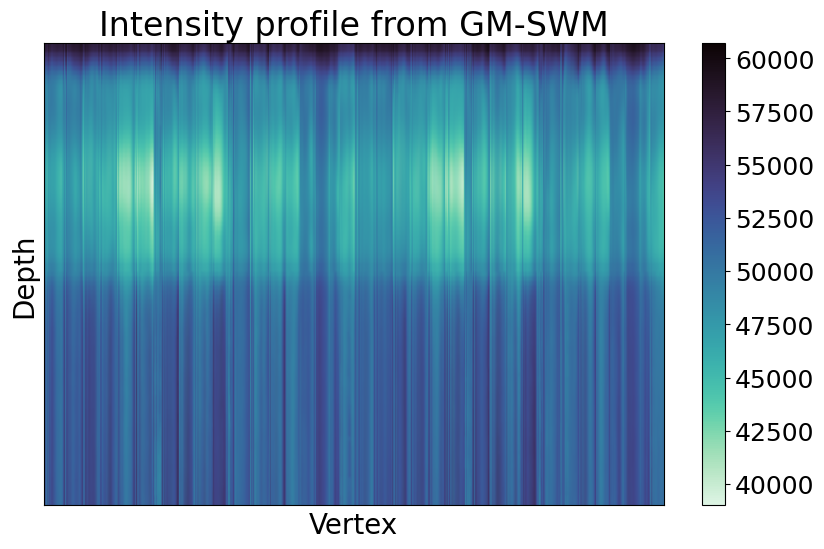

In [8]:
plot_intensity_profile(BB_int_profile, mask_5k)

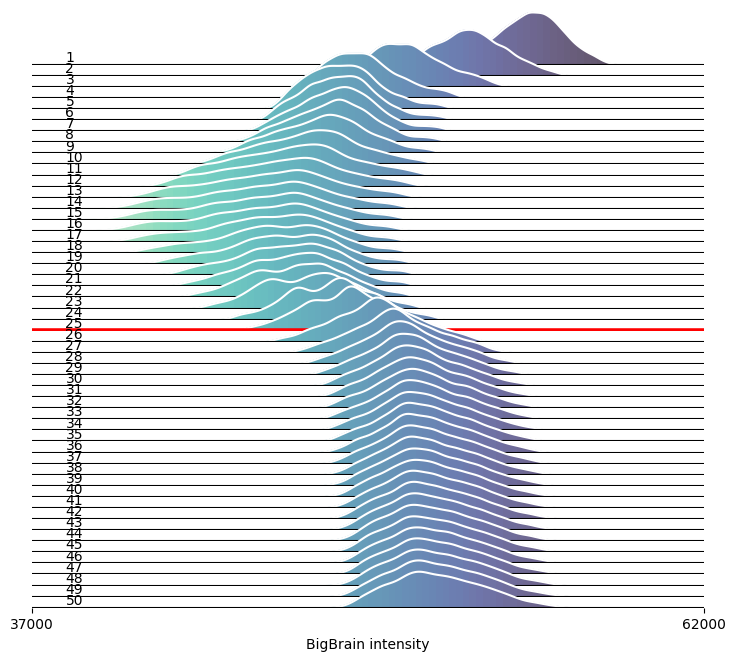

In [9]:
rows_to_extract = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]
BB_extracted_rows = BB_int_profile[rows_to_extract]
plot_ridgeplot(BB_extracted_rows[:,mask_5k], matrix_df=None, Cmap='mako_r', Range=(37000, 62000), Xlab="BigBrain intensity", save_path=None, WM=25)

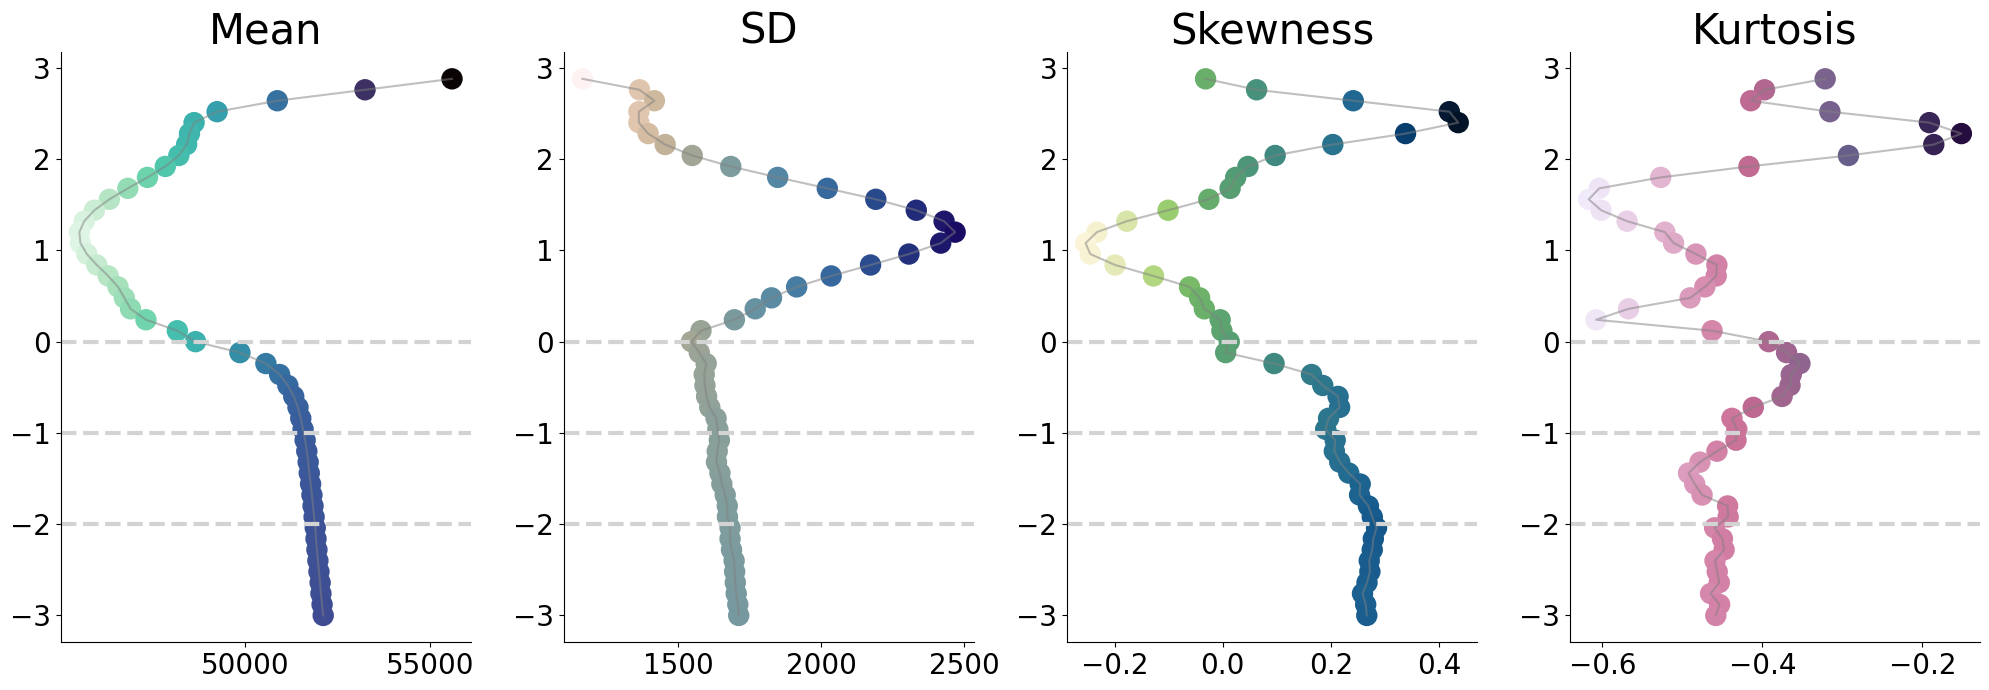

In [10]:
plot_intensity_moments(BB_extracted_rows, mask_5k)

## Intensity profiles: from GM to SWM (AHEAD - Bielschowsky)

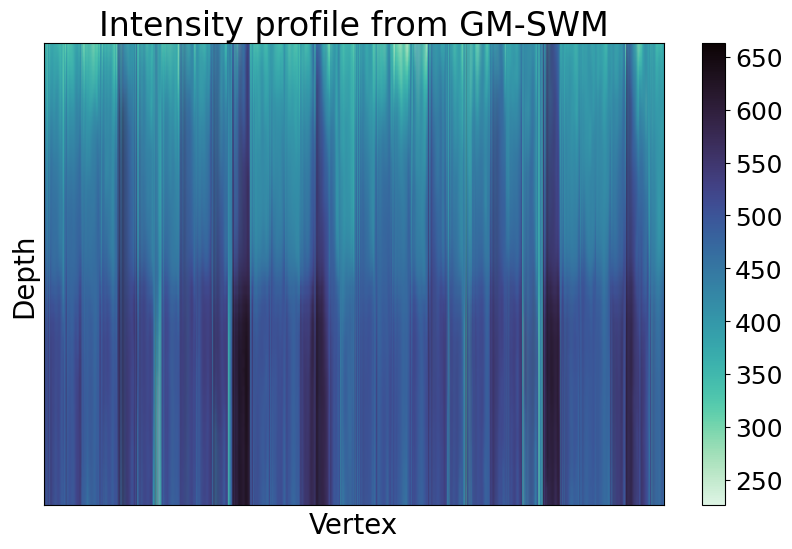

In [11]:
plot_intensity_profile(AB_int_profile, mask_5k)

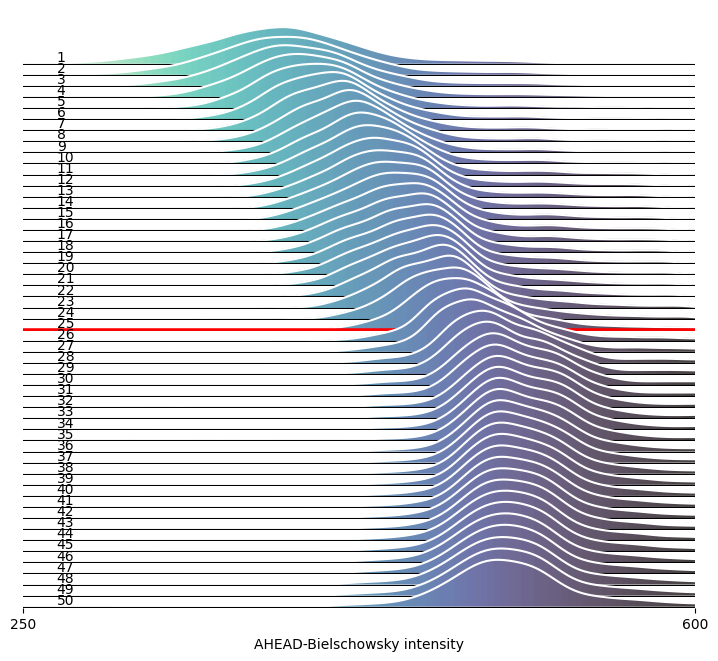

In [12]:
rows_to_extract = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]
AB_extracted_rows = AB_int_profile[rows_to_extract]
plot_ridgeplot(AB_extracted_rows[:,mask_5k], matrix_df=None, Cmap='mako_r', Range=(250, 600), Xlab="AHEAD-Bielschowsky intensity", save_path=None, WM=25)

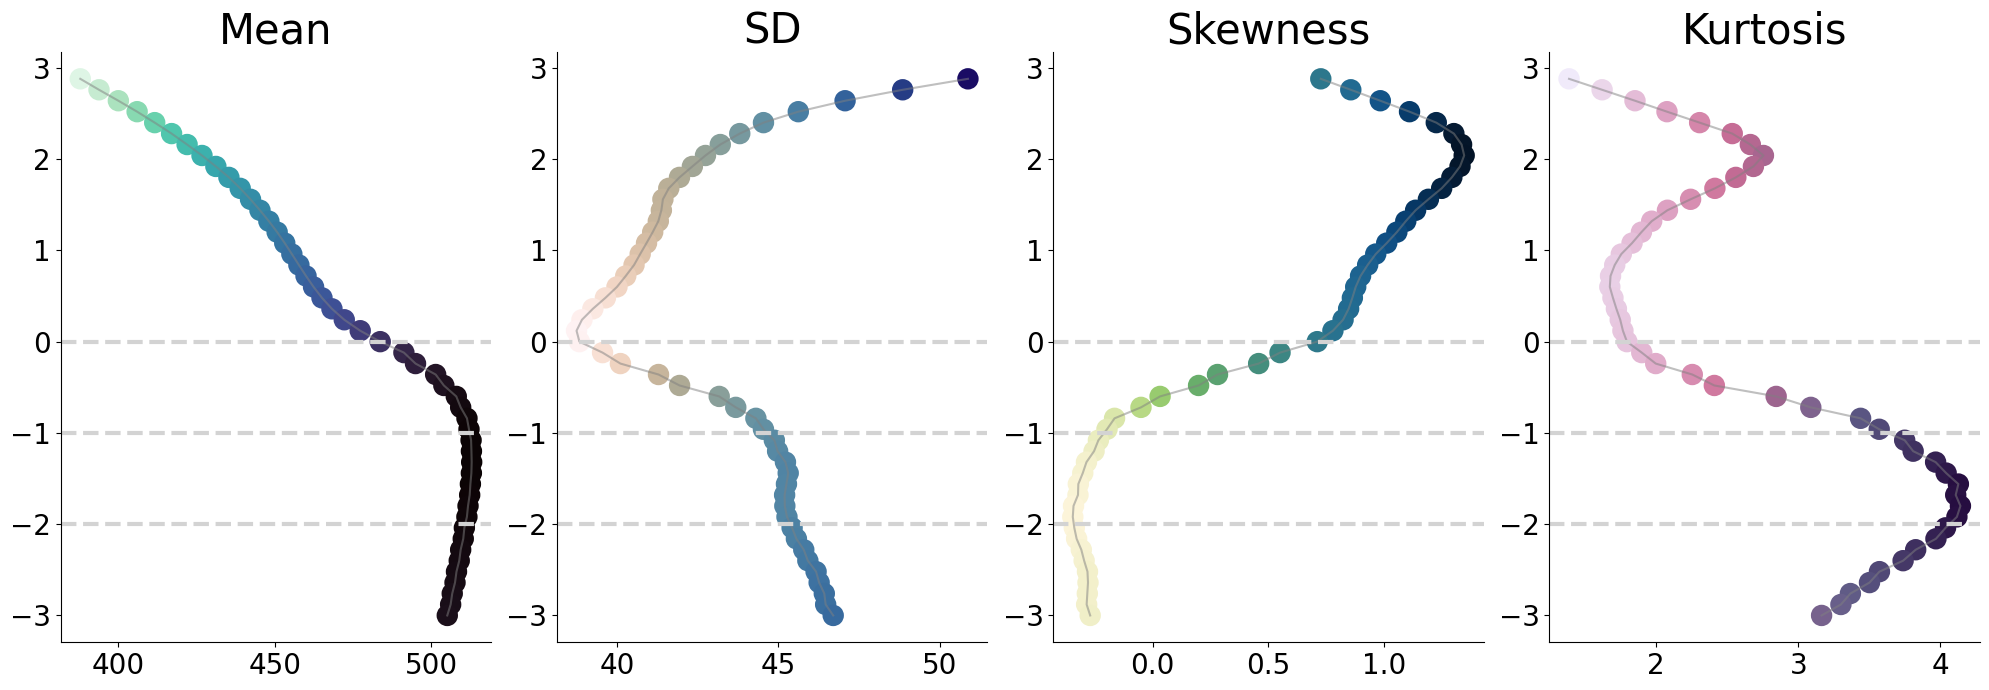

In [13]:
plot_intensity_moments(AB_extracted_rows, mask_5k)

## Intensity profiles: from GM to SWM (AHEAD - Parvalbumin)

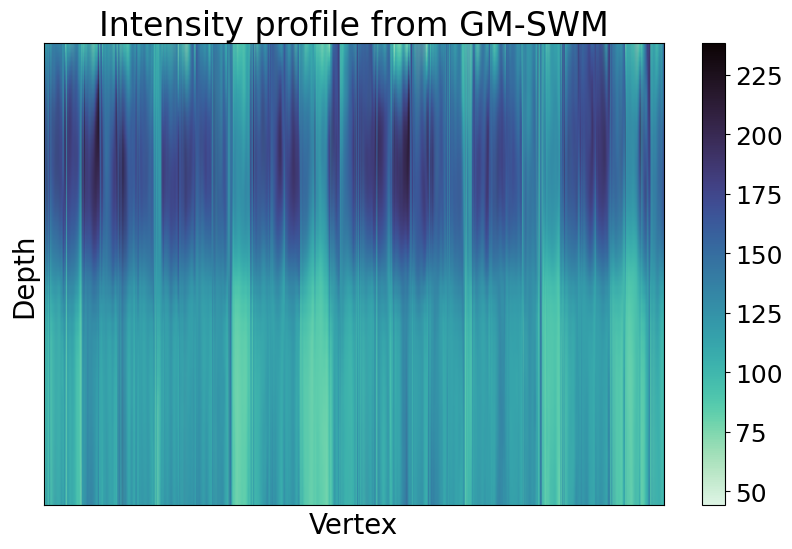

In [14]:
plot_intensity_profile(AP_int_profile, mask_5k)

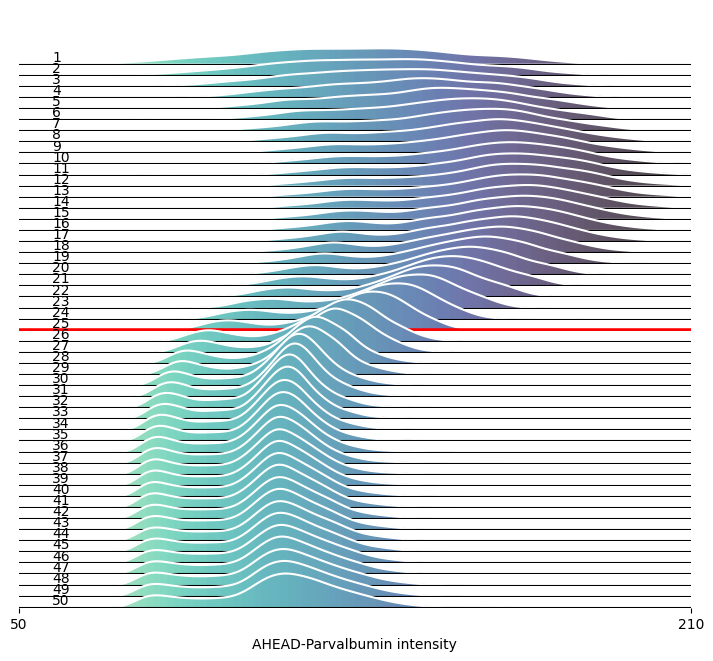

In [15]:
rows_to_extract = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]
AP_extracted_rows = AP_int_profile[rows_to_extract]
plot_ridgeplot(AP_extracted_rows[:,mask_5k], matrix_df=None, Cmap='mako_r', Range=(50, 210), Xlab="AHEAD-Parvalbumin intensity", save_path=None, WM=25)

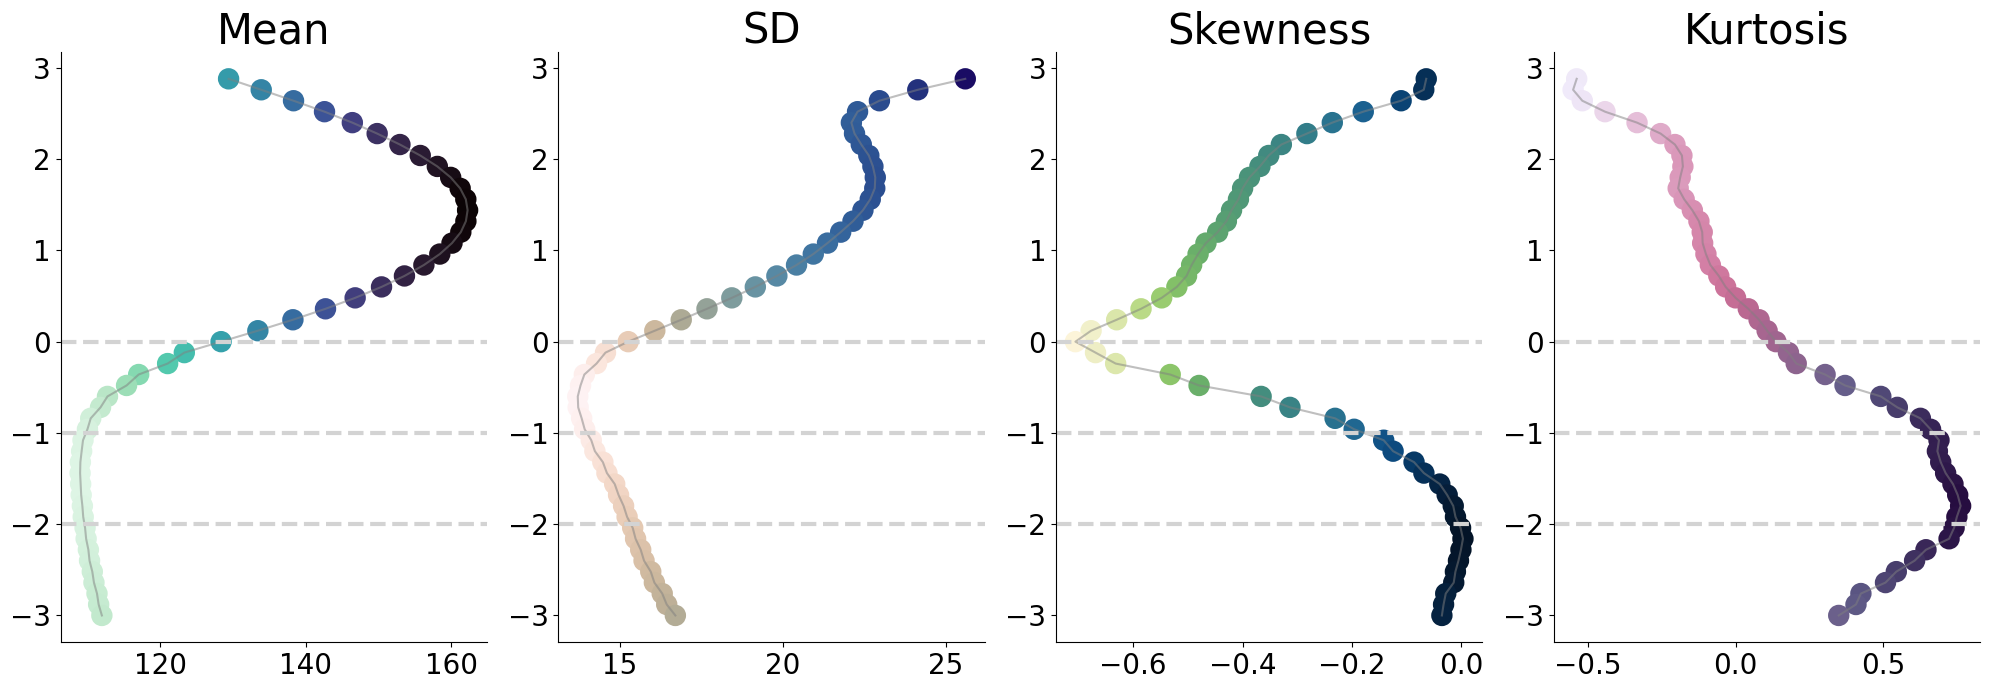

In [16]:
plot_intensity_moments(AP_extracted_rows, mask_5k)

## Intensity profiles: from GM to SWM (T1 map)

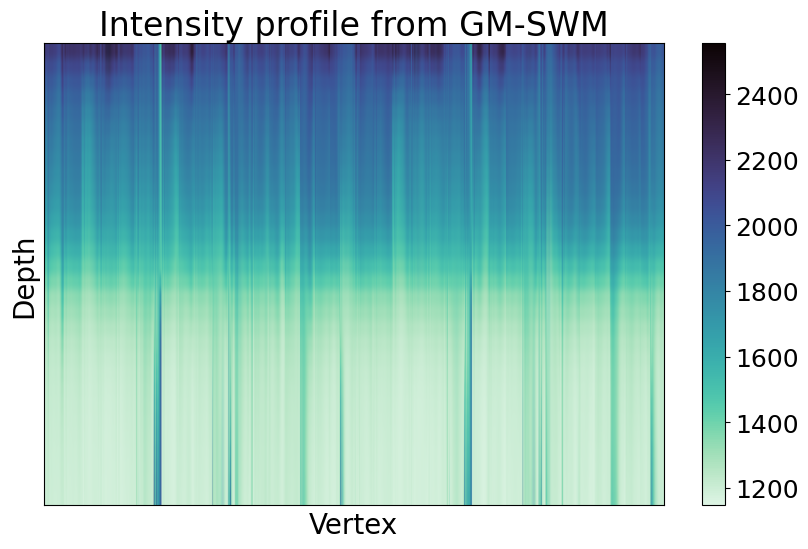

In [25]:
plot_intensity_profile(T1map_int_profile, mask_5k)

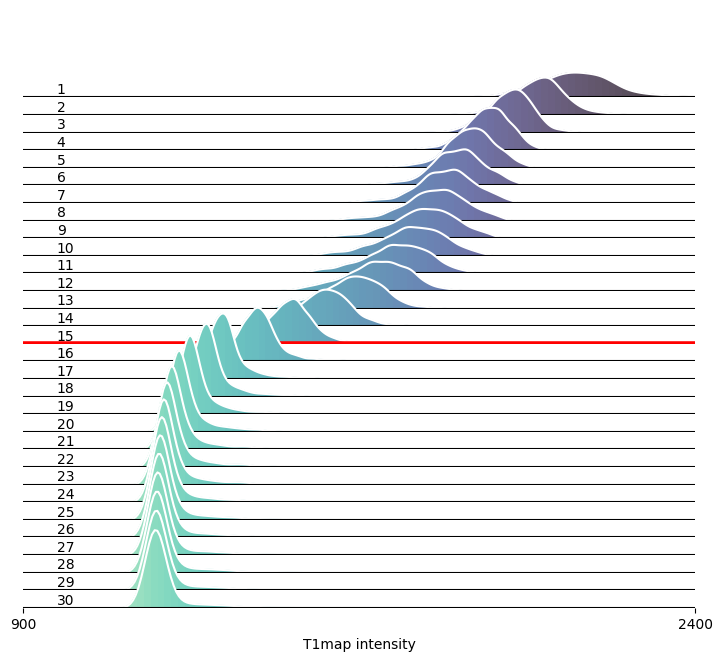

In [26]:
plot_ridgeplot(T1map_int_profile[:,mask_5k], matrix_df=None, Cmap='mako_r', Range=(900, 2400), Xlab="T1map intensity", save_path=None, WM=15)

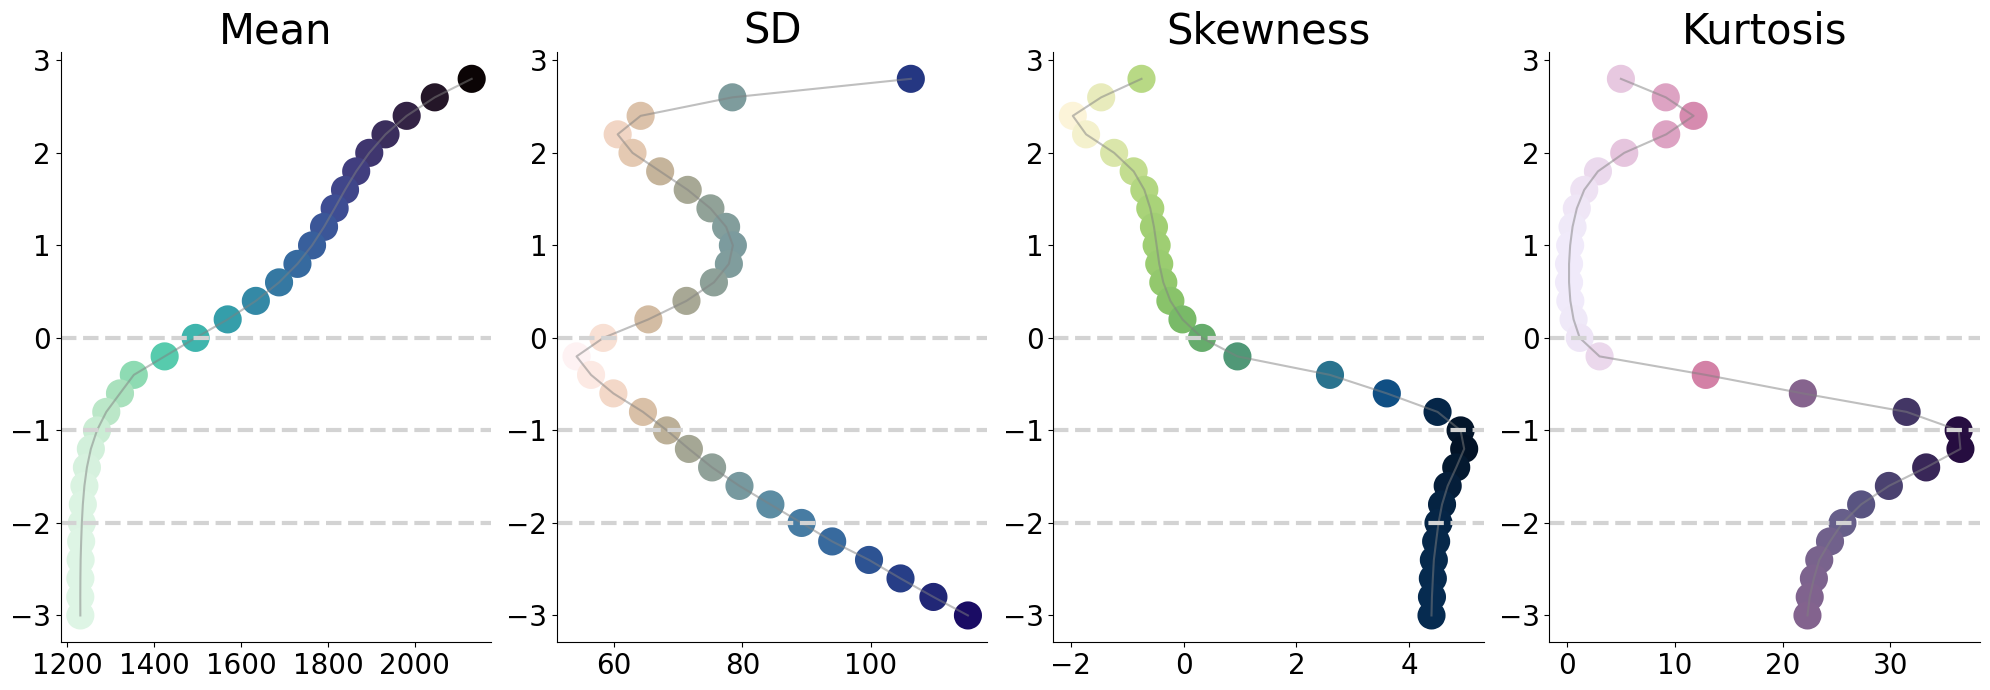

In [27]:
plot_intensity_moments(T1map_int_profile, mask_5k)

## Intensity profiles: from GM to SWM (MTsat)

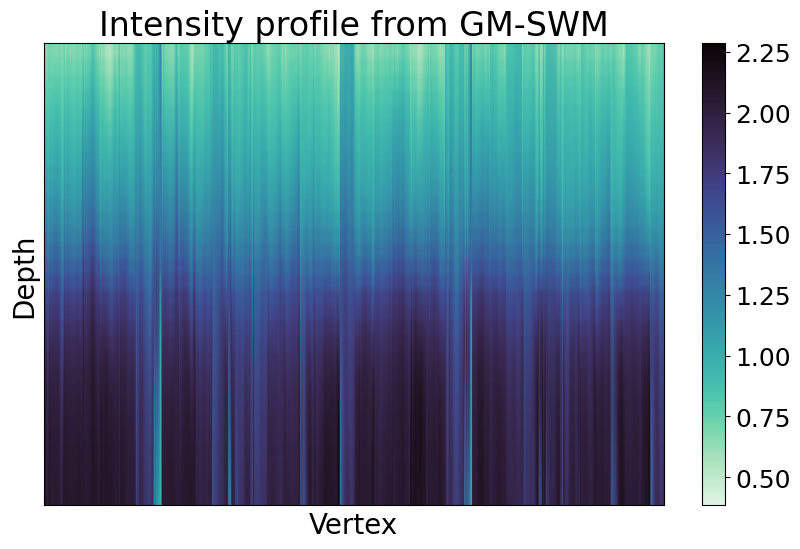

In [20]:
plot_intensity_profile(MTSAT_int_profile, mask_5k)

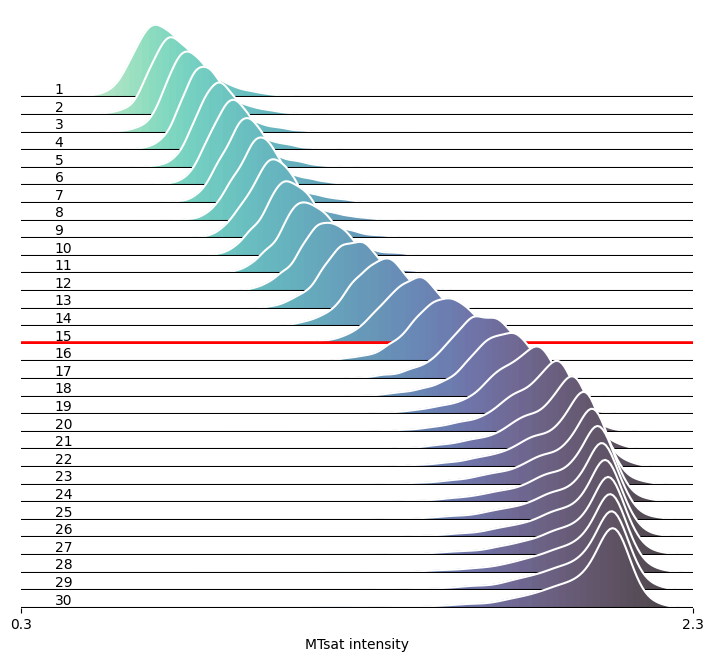

In [21]:
plot_ridgeplot(MTSAT_int_profile[:,mask_5k], matrix_df=None, Cmap='mako_r', Range=(0.3, 2.3), Xlab="MTsat intensity", save_path=None, WM=15)

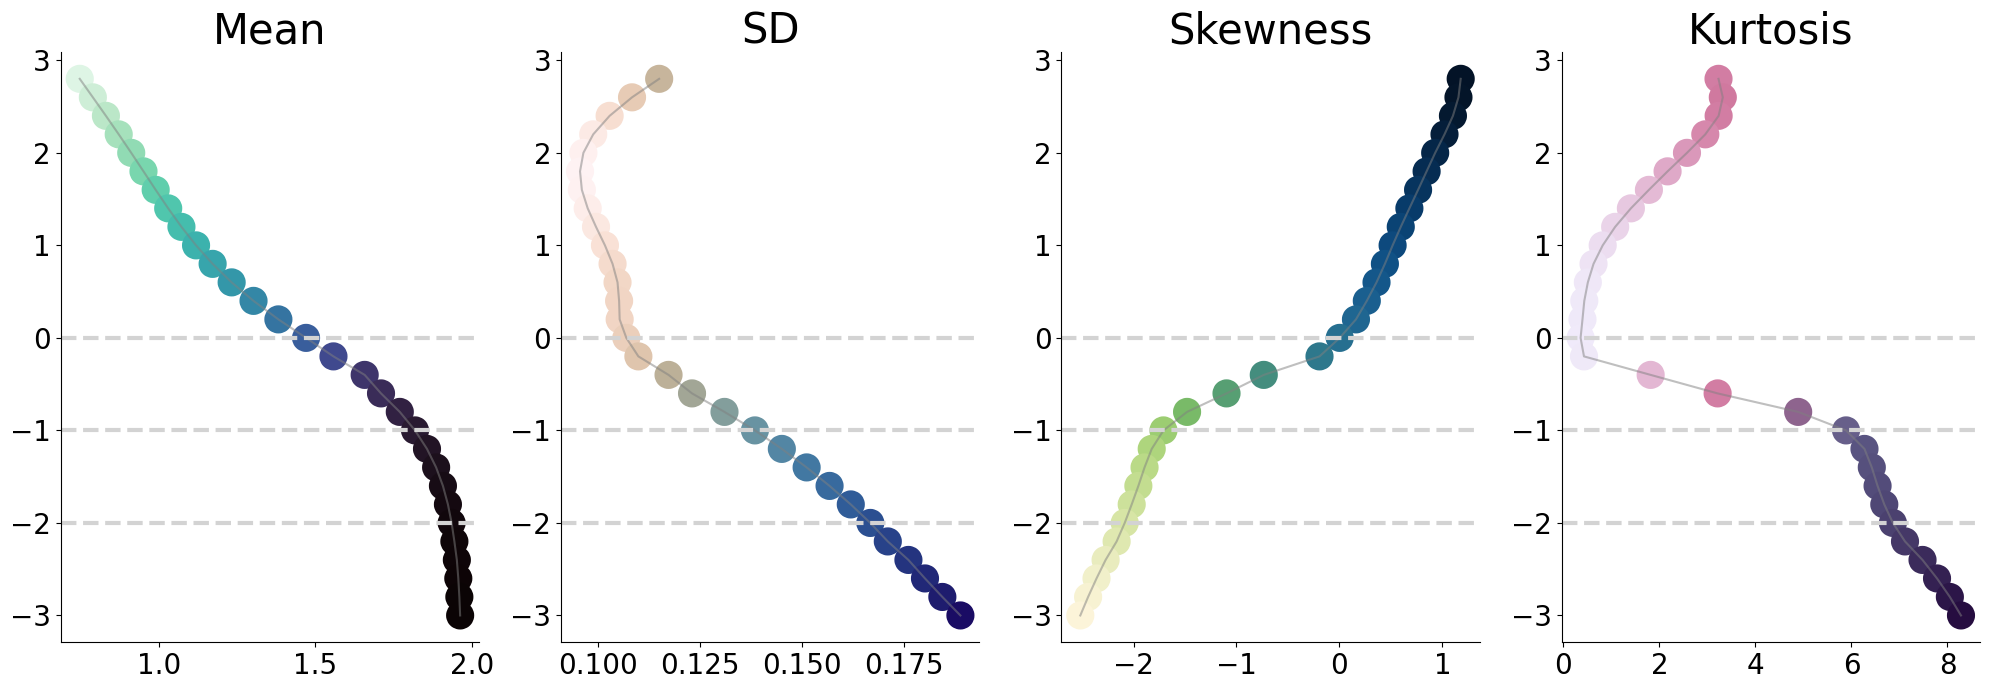

In [22]:
plot_intensity_moments(MTSAT_int_profile, mask_5k)